<a href="https://colab.research.google.com/github/AlvinScrp/d2l-zh-pytorch-colab/blob/main/chapter_natural-language-processing-applications/sentiment-analysis-and-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install numpy d2l --no-deps # installing d2l # installing d2l


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 5.2 MB/s eta 0:00:00


# 情感分析及数据集
:label:`sec_sentiment`

随着在线社交媒体和评论平台的快速发展，大量评论的数据被记录下来。这些数据具有支持决策过程的巨大潜力。
*情感分析*（sentiment analysis）研究人们在文本中
（如产品评论、博客评论和论坛讨论等）“隐藏”的情绪。
它在广泛应用于政治（如公众对政策的情绪分析）、
金融（如市场情绪分析）和营销（如产品研究和品牌管理）等领域。

由于情感可以被分类为离散的极性或尺度（例如，积极的和消极的），我们可以将情感分析看作一项文本分类任务，它将可变长度的文本序列转换为固定长度的文本类别。在本章中，我们将使用斯坦福大学的[大型电影评论数据集（large movie review dataset）](https://ai.stanford.edu/~amaas/data/sentiment/)进行情感分析。它由一个训练集和一个测试集组成，其中包含从IMDb下载的25000个电影评论。在这两个数据集中，“积极”和“消极”标签的数量相同，表示不同的情感极性。


In [3]:
import os
import torch
from torch import nn
from d2l import torch as d2l

##  读取数据集

首先，下载并提取路径`../data/aclImdb`中的IMDb评论数据集。


In [4]:
d2l.DATA_HUB['aclImdb'] = (
    'https://huggingface.co/datasets/NolanChai/aclImdb_v1/resolve/main/aclImdb_v1.tar.gz',
    '01ada507287d82875905620988597833ad4e0903')

data_dir = d2l.download_extract('aclImdb', 'aclImdb')

接下来，读取训练和测试数据集。每个样本都是一个评论及其标签：1表示“积极”，0表示“消极”。


In [5]:
def read_imdb(data_dir, is_train):
    """读取IMDb评论数据集文本序列和标签"""
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test',
                                   label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels

train_data = read_imdb(data_dir, is_train=True)
print('训练集数目：', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('标签：', y, 'review:', x[0:60])

训练集数目： 25000
标签： 1 review: I remember this movie from the 50s when I was in college. It
标签： 1 review: This film contains the one ingredient that all revenge movie
标签： 1 review: Of all the breakdancing / hip-hop films released between 198


In [6]:
for review in train_data[0][:5]:
  print(review)

I actually quite enjoyed this show. Even as a youngster I was interested in all sports and that included horse racing. It was always going to be difficult to make a series based on racing corruption and at the same time get permission from the race tracks to record filming about this controversial subject. One episode I particularly remember centred around a horse expected to win a big race that looked a bit off colour. A syringe was found on the stable floor and everyone thought it had been drugged but nothing showed up in the blood tests. All too late they realised the horse hadnt been doped but had had its knee cartilage removed. Like running a car with no oil and the engine seizing up, the horse broke down with tragic consequences.
So I'm at home, flipping channels one night, and I come across this man wearing heels and makeup, standing in front of a colored background on HBO. Naturally, I did a double-take and decided I'd watch for a little while. I didn't change the channel until

## 预处理数据集

将每个单词作为一个词元，过滤掉出现不到5次的单词，我们从训练数据集中创建一个词表。


In [7]:
train_tokens = d2l.tokenize(train_data[0], token='word')
print(train_tokens[0])
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])
print(vocab['I'])
print(vocab.token_freqs[:10])

['I', 'actually', 'quite', 'enjoyed', 'this', 'show.', 'Even', 'as', 'a', 'youngster', 'I', 'was', 'interested', 'in', 'all', 'sports', 'and', 'that', 'included', 'horse', 'racing.', 'It', 'was', 'always', 'going', 'to', 'be', 'difficult', 'to', 'make', 'a', 'series', 'based', 'on', 'racing', 'corruption', 'and', 'at', 'the', 'same', 'time', 'get', 'permission', 'from', 'the', 'race', 'tracks', 'to', 'record', 'filming', 'about', 'this', 'controversial', 'subject.', 'One', 'episode', 'I', 'particularly', 'remember', 'centred', 'around', 'a', 'horse', 'expected', 'to', 'win', 'a', 'big', 'race', 'that', 'looked', 'a', 'bit', 'off', 'colour.', 'A', 'syringe', 'was', 'found', 'on', 'the', 'stable', 'floor', 'and', 'everyone', 'thought', 'it', 'had', 'been', 'drugged', 'but', 'nothing', 'showed', 'up', 'in', 'the', 'blood', 'tests.', 'All', 'too', 'late', 'they', 'realised', 'the', 'horse', 'hadnt', 'been', 'doped', 'but', 'had', 'had', 'its', 'knee', 'cartilage', 'removed.', 'Like', 'runn

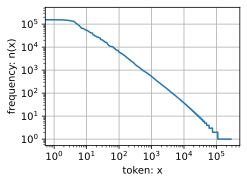

In [8]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

In [9]:
len(vocab.token_freqs)

280617

在词元化之后，让我们绘制评论词元长度的直方图。


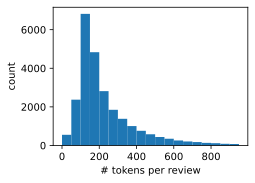

In [10]:
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review')
d2l.plt.ylabel('count')
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50));

正如我们所料，评论的长度各不相同。为了每次处理一小批量这样的评论，我们通过截断和填充将每个评论的长度设置为500。这类似于 :numref:`sec_machine_translation`中对机器翻译数据集的预处理步骤。


In [11]:
num_steps = 500  # 序列长度
train_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

torch.Size([25000, 500])


## 创建数据迭代器

现在我们可以创建数据迭代器了。在每次迭代中，都会返回一小批量样本。


In [12]:
train_iter = d2l.load_array((train_features,torch.tensor(train_data[1])), 64)

for X, y in train_iter:
    print('X:', X.shape, ', y:', y.shape)
    break
print('小批量数目：', len(train_iter))

X: torch.Size([64, 500]) , y: torch.Size([64])
小批量数目： 391


## 整合代码

最后，我们将上述步骤封装到`load_data_imdb`函数中。它返回训练和测试数据迭代器以及IMDb评论数据集的词表。


In [13]:
def load_data_imdb(batch_size, num_steps=500):
    """返回数据迭代器和IMDb评论数据集的词表"""
    data_dir = d2l.download_extract('aclImdb', 'aclImdb')
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])), batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),  batch_size,  is_train=False)
    return train_iter, test_iter, vocab

In [14]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]

在文本分类任务（如情感分析）中，可变长度的文本序列将被转换为固定长度的类别。在下面的BiRNN类中，虽然文本序列的每个词元经由嵌入层（self.embedding）获得其单独的预训练GloVe表示，但是整个序列由双向循环神经网络（self.encoder）编码。更具体地说，双向长短期记忆网络在初始和最终时间步的隐状态（在最后一层）被连结起来作为文本序列的表示。然后，通过一个具有两个输出（“积极”和“消极”）的全连接层（self.decoder），将此单一文本表示转换为输出类别。

In [15]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 将bidirectional设置为True以获取双向循环神经网络
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # inputs的形状是（批量大小，时间步数）
        # 因为长短期记忆网络要求其输入的第一个维度是时间维，
        # 所以在获得词元表示之前，输入会被转置。
        # 输出形状为（时间步数，批量大小，词向量维度）
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # 返回上一个隐藏层在不同时间步的隐状态，
        # outputs的形状是（时间步数，批量大小，2*隐藏单元数）
        outputs, _ = self.encoder(embeddings)
        # 连结初始和最终时间步的隐状态，作为全连接层的输入，
        # 其形状为（批量大小，4*隐藏单元数）
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [16]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        # 微调BERT中所需
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1], legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[2], metric[1] / metric[3], None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

loss 0.211, train acc 0.919, test acc 0.855
1267.6 examples/sec on [device(type='cuda', index=0)]


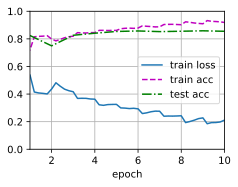

In [17]:
# net = BiRNN(len(vocab), embed_size=100,num_hiddens=100,num_layers=2)
# def init_weights(m):
#     if type(m) == nn.Linear:
#         nn.init.xavier_uniform_(m.weight)
#     if type(m) == nn.LSTM:
#         for param in m._flat_weights_names:
#             if "weight" in param:
#                 nn.init.xavier_uniform_(m._parameters[param])
# net.apply(init_weights);


# print(embeds.shape)
# #我们使用这些预训练的词向量来表示评论中的词元，并且在训练期间不要更新这些向量。
# net.embedding.weight.data.copy_(embeds)
# net.embedding.weight.requires_grad = False
# lr, num_epochs = 0.01, 10
# trainer = torch.optim.Adam(net.parameters(), lr=lr)
# loss = nn.CrossEntropyLoss(reduction="none")
# devices = d2l.try_all_gpus()
# train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices)


loss 0.242, train acc 0.902, test acc 0.851
1114.3 examples/sec on [device(type='cuda', index=0)]


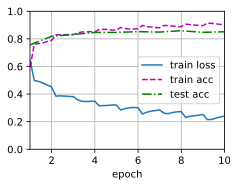

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionBiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
        super(AttentionBiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                               bidirectional=True)

        # --- 新增: 注意力机制层 ---
        # 这是一个简单的“加性注意力”实现
        # W_q * h_t + b -> tanh -> v^T * tanh(...)
        self.attention = nn.Sequential(
            nn.Linear(2 * num_hiddens, 2 * num_hiddens), # W
            nn.Tanh(),
            nn.Linear(2 * num_hiddens, 1) # v
        )

        # --- 修改: 解码器（分类器）的输入维度 ---
        # 输入不再是拼接后的 4*hiddens，而是加权求和后的 2*hiddens
        self.decoder = nn.Linear(2 * num_hiddens, 2)

    def forward(self, inputs):
        # inputs 形状: (批量大小, 时间步数)
        # embeddings 形状: (时间步数, 批量大小, 词向量维度)
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()

        # outputs 形状: (时间步数, 批量大小, 2 * 隐藏单元数)
        outputs, _ = self.encoder(embeddings)

        # --- 核心修改: 使用注意力机制聚合信息 ---

        # 1. 调整 outputs 形状以方便计算
        # -> (批量大小, 时间步数, 2 * 隐藏单元数)
        outputs_permuted = outputs.permute(1, 0, 2)

        # 2. 计算每个时间步的注意力分数
        # self.attention(outputs_permuted) 的形状: (批量大小, 时间步数, 1)
        # .squeeze(2) 后, scores 形状: (批量大小, 时间步数)
        scores = self.attention(outputs_permuted).squeeze(2)

        # 3. 使用 softmax 将分数转换为概率（权重）
        # attention_weights 形状: (批量大小, 时间步数)
        attention_weights = F.softmax(scores, dim=1)

        # 4. 计算上下文向量（加权求和）
        # (批量大小, 1, 时间步数) @ (批量大小, 时间步数, 2*h) -> (批量大小, 1, 2*h)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), outputs_permuted)
        # .squeeze(1) 后, context_vector 形状: (批量大小, 2 * 隐藏单元数)
        context_vector = context_vector.squeeze(1)

        # 5. 将上下文向量输入解码器进行分类
        outs = self.decoder(context_vector)
        return outs

net = AttentionBiRNN(len(vocab), embed_size=100,num_hiddens=100,num_layers=2)
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
net.apply(init_weights);


print(embeds.shape)
#我们使用这些预训练的词向量来表示评论中的词元，并且在训练期间不要更新这些向量。
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

lr, num_epochs = 0.01, 10
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
devices = d2l.try_all_gpus()
train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices)


In [ ]:
import math
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# ============ 辅助函数 ============
def transpose_qkv(X, num_heads):
    """变换多头注意力的输入"""
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    X = X.permute(0, 2, 1, 3)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    """逆转transpose_qkv的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

# ============ 注意力机制 ============
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout):
        super(DotProductAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.attention_weights = None

    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        if valid_lens is not None:
            attention_weights = self.masked_softmax(scores, valid_lens)
        else:
            attention_weights = F.softmax(scores, dim=-1)
        self.attention_weights = attention_weights
        return torch.bmm(self.dropout(attention_weights), values)

    def masked_softmax(self, X, valid_lens):
        """遮蔽softmax操作"""
        if valid_lens is None:
            return F.softmax(X, dim=-1)
        else:
            shape = X.shape
            if valid_lens.dim() == 1:
                valid_lens = torch.repeat_interleave(valid_lens, shape[1])
            else:
                valid_lens = valid_lens.reshape(-1)
            X = X.reshape(-1, shape[-1])
            for i, length in enumerate(valid_lens):
                if length > 0:
                    X[i, length:] = -1e6
            return F.softmax(X.reshape(shape), dim=-1)

# ============ 基础模块 ============
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs):
        super(PositionWiseFFN, self).__init__()
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout):
        super(AddNorm, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        output = self.attention(queries, keys, values, valid_lens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False):
        super(EncoderBlock, self).__init__()
        self.attention = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

# ============ 情感分类模型 ============
class TransformerSentimentClassifier(nn.Module):
    """基于Transformer编码器的情感分类模型"""
    def __init__(self, vocab_size, num_hiddens, num_heads, num_layers,
                 ffn_num_hiddens, num_classes, dropout=0.1, max_len=512):
        super(TransformerSentimentClassifier, self).__init__()
        self.num_hiddens = num_hiddens

        # 词嵌入和位置编码
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout, max_len)

        # Transformer编码器层
        self.encoder_blocks = nn.ModuleList([
            EncoderBlock(
                key_size=num_hiddens,
                query_size=num_hiddens,
                value_size=num_hiddens,
                num_hiddens=num_hiddens,
                norm_shape=num_hiddens,
                ffn_num_input=num_hiddens,
                ffn_num_hiddens=ffn_num_hiddens,
                num_heads=num_heads,
                dropout=dropout
            ) for _ in range(num_layers)
        ])

        # 分类头
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(num_hiddens, num_classes)

    def forward(self, X, valid_lens=None):
        """
        X: (batch_size, seq_len) - 输入序列的token索引
        valid_lens: (batch_size,) - 每个序列的有效长度
        """
        # 词嵌入和位置编码
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))

        # 通过编码器层
        for block in self.encoder_blocks:
            X = block(X, valid_lens)

        # 使用[CLS] token(第一个位置)进行分类
        # 或者使用平均池化
        # pooled = X[:, 0, :]  # 取第一个token的输出
        pooled = X.mean(dim=1)  # 或者: 平均池化

        # 分类
        output = self.classifier(self.dropout(pooled))
        return output


In [ ]:

num_classes = 2         # 预训练embedding维度
num_hiddens = 100          # 统一hidden维度
num_heads = 2              # 每头32维
num_layers = 4             # 增加深度
ffn_num_hiddens = 256      # 2倍扩展
dropout = 0.1
lr = 0.0001               # 降低学习率!
batch_size = 32           # 减小batch_size
num_epochs = 20           # 增加训练轮数

net = TransformerSentimentClassifier(
        vocab_size=len(vocab),
        num_hiddens=num_hiddens,
        num_heads=num_heads,
        num_layers=num_layers,
        ffn_num_hiddens=ffn_num_hiddens,
        num_classes=num_classes,
        dropout=dropout,
        max_len=num_steps
    )


# print(embeds.shape)
# #我们使用这些预训练的词向量来表示评论中的词元，并且在训练期间不要更新这些向量。
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False
# net.decoder.embedding.weight.data.copy_(embeds)
# net.decoder.embedding.weight.requires_grad = False

# lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
devices = d2l.try_all_gpus()
train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices)

###将BERT集成到您现有的训练代码中 完全兼容d2l的训练框架

In [21]:
data_dir = d2l.download_extract('aclImdb', 'aclImdb')
train_data = read_imdb(data_dir, True)
test_data = read_imdb(data_dir, False)
train_texts,train_labels= train_data
test_texts,test_labels=test_data
print(len(train_data[0]))
print(len(train_data[1]))
print(len(train_data))

25000
25000
2


training on [device(type='cuda', index=0)]


/usr/local/lib/python3.12/dist-packages/d2l/torch.py:3179: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  self.data = [a + float(b) for a, b in zip(self.data, args)]


KeyboardInterrupt: 

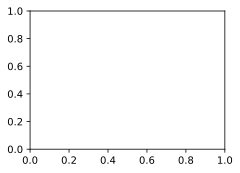

In [24]:
"""
将BERT集成到您现有的训练代码中
完全兼容d2l的训练框架
"""

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from d2l import torch as d2l

# ============ BERT模型定义 ============
class BERTSentimentClassifier(nn.Module):
    """BERT情感分类器 - 兼容您的训练代码"""
    def __init__(self, bert_model_name='bert-base-uncased', num_classes=2,
                 dropout=0.1):
        super(BERTSentimentClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        """前向传播 - 返回logits"""
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        return self.classifier(self.dropout(pooled))

# ============ 使用DistilBERT (推荐!) ============
class DistilBERTSentimentClassifier(nn.Module):
    """使用DistilBERT - 速度快2倍, 显存少40%"""
    def __init__(self, num_classes=2, dropout=0.1):
        super(DistilBERTSentimentClassifier, self).__init__()
        from transformers import DistilBertModel

        # DistilBERT: 66M参数 vs BERT: 110M参数
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # DistilBERT没有pooler_output, 使用第一个token
        pooled_output = outputs.last_hidden_state[:, 0]
        return self.classifier(self.dropout(pooled_output))


# ============ 数据集包装器 ============
class BERTDatasetWrapper:
    """
    包装您现有的数据,使其兼容BERT
    用法: 替换您原来的数据迭代器
    """
    def __init__(self, data_iter, tokenizer, max_length=500, device=None):
        """
        data_iter: 您原来的数据迭代器 (返回 features, labels)
        tokenizer: BERT tokenizer
        max_length: 最大序列长度
        """
        self.data_iter = data_iter
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.device = device

    def __iter__(self):
        for batch in self.data_iter:
            if len(batch) == 2:
                features, labels = batch
            else:
                # 如果有valid_lens等额外信息
                features, labels = batch[0], batch[-1]

            # 如果features已经是tensor,需要转换回文本
            # 这里假设您有vocab.to_tokens方法
            # 实际使用时需要根据您的数据格式调整
            yield self._convert_batch(features, labels)

    def _convert_batch(self, features, labels):
        """将batch转换为BERT格式"""
        # 如果features是token ids,需要转回文本再用BERT tokenizer
        # 这里展示直接使用BERT tokenizer的情况
        batch_size = labels.shape[0]

        # 创建空的input_ids和attention_mask
        input_ids = torch.zeros((batch_size, self.max_length), dtype=torch.long)
        attention_mask = torch.zeros((batch_size, self.max_length), dtype=torch.long)

        # 这里需要根据您的数据格式填充
        # 示例: 如果features已经是适合的格式
        if isinstance(features, torch.Tensor):
            seq_len = min(features.shape[1], self.max_length)
            input_ids[:, :seq_len] = features[:, :seq_len]
            attention_mask[:, :seq_len] = 1

        if self.device:
            input_ids = input_ids.to(self.device)
            attention_mask = attention_mask.to(self.device)
            labels = labels.to(self.device)

        return input_ids, attention_mask, labels


# ============ 修改后的训练函数 ============
def train_bert_epoch(net, train_iter, loss, updater, device, tokenizer=None):
    """
    单个epoch训练 - 兼容d2l风格
    与train_ch13类似,但适配BERT输入
    """
    net.train()
    metric = d2l.Accumulator(3)  # 训练损失总和, 准确数, 样本数

    for batch_idx, batch in enumerate(train_iter):
        # 解析batch
        if len(batch) == 3:
            input_ids, attention_mask, labels = batch
        else:
            # 如果使用BERTDatasetWrapper
            input_ids, attention_mask, labels = batch

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # 前向传播
        y_hat = net(input_ids, attention_mask)
        l = loss(y_hat, labels)

        # 反向传播
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.sum().backward()
            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
            updater.step()
        else:
            # 如果使用自定义updater
            l.sum().backward()
            updater(input_ids.shape[0])

        # 统计
        metric.add(l.sum(), d2l.accuracy(y_hat, labels), labels.numel())

    return metric[0] / metric[2], metric[1] / metric[2]


def evaluate_bert_accuracy(net, data_iter, device):
    """评估准确率 - 兼容d2l风格"""
    net.eval()
    metric = d2l.Accumulator(2)  # 正确预测数, 总数

    with torch.no_grad():
        for batch in data_iter:
            if len(batch) == 3:
                input_ids, attention_mask, labels = batch
            else:
                input_ids, attention_mask, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            y_hat = net(input_ids, attention_mask)
            metric.add(d2l.accuracy(y_hat, labels), labels.numel())

    return metric[0] / metric[1]


def train_bert_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                    devices, scheduler=None):
    """
    完整训练流程 - 完全兼容您的train_ch13
    """
    print('training on', devices)

    if isinstance(devices, list) and len(devices) > 1:
        # 多GPU
        net = nn.DataParallel(net, device_ids=devices)

    device = devices[0] if isinstance(devices, list) else devices
    net = net.to(device)

    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                           legend=['train loss', 'train acc', 'test acc'])

    for epoch in range(num_epochs):
        # 训练
        train_loss, train_acc = train_bert_epoch(
            net, train_iter, loss, trainer, device
        )

        # 验证
        test_acc = evaluate_bert_accuracy(net, test_iter, device)

        # 学习率调度
        if scheduler is not None:
            scheduler.step()

        # 绘图
        animator.add(epoch + 1, (train_loss, train_acc, test_acc))

        print(f'Epoch {epoch + 1}: '
              f'loss {train_loss:.3f}, '
              f'train acc {train_acc:.3f}, '
              f'test acc {test_acc:.3f}')

    print(f'Training completed in {timer.stop():.1f} sec')
    print(f'Final: train acc {train_acc:.3f}, test acc {test_acc:.3f}')




# 1. 初始化BERT tokenizer
# DistilBERT 和 BERT 使用相同的tokenizer，因为 DistilBERT 是从 BERT 蒸馏而来的，保留了相同的词汇表和分词方式。
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 2. 替换模型定义
num_classes = 2
dropout = 0.1
batch_size = 16
num_steps = 128  # 最大序列长度
lr = 2e-5  # BERT学习率
num_epochs = 5

 # 或 'distilbert-base-uncased' (更快)
net = DistilBERTSentimentClassifier(
    num_classes=num_classes,
    dropout=dropout
)

# 注意: BERT自带预训练embedding,不需要手动加载embeds!

# 3. 数据处理需要改用BERT tokenizer
# 假设您有 train_texts, train_labels 等
class BERTDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=500):
        self.encodings = tokenizer(
            texts,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors='pt'
        )
        self.labels = torch.tensor(labels)

    def __getitem__(self, idx):
        return (
            self.encodings['input_ids'][idx],
            self.encodings['attention_mask'][idx],
            self.labels[idx]
        )

    def __len__(self):
        return len(self.labels)


# 创建数据集 (需要您的原始文本数据)
train_dataset = BERTDataset(train_texts, train_labels, tokenizer, max_length=num_steps)
test_dataset = BERTDataset(test_texts, test_labels, tokenizer, max_length=num_steps)

train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 优化器和调度器
trainer = AdamW(net.parameters(), lr=lr, weight_decay=0.01)
total_steps = len(train_iter) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    trainer,
    num_warmup_steps=total_steps // 10,
    num_training_steps=total_steps
)

# 损失函数
loss = nn.CrossEntropyLoss(reduction="none")

# 训练
devices = d2l.try_all_gpus()
train_bert_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices, scheduler)

print("\n" + "="*60)
print("关键修改点总结:")
print("="*60)
print("1. 模型: TransformerSentimentClassifier → BERTSentimentClassifier")
print("2. 学习率: 0.01 → 2e-5 (BERT需要小学习率)")
print("3. 数据: vocab索引 → BERT tokenizer")
print("4. 优化器: Adam → AdamW (带weight decay)")
print("5. 添加: 学习率warmup scheduler")
print("6. 训练函数: train_ch13 → train_bert_ch13")





In [18]:
print(len(train_data[0]))
print(len(train_data[1]))
print(len(train_data))

25000
25000
2


In [ ]:
"""
BERT在IMDB情感分类上的完整实战示例
可直接运行的代码
"""

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
from tqdm import tqdm
import os

# ============ 模型定义 ============
class BERTForSentiment(nn.Module):
    def __init__(self, bert_name='bert-base-uncased', num_classes=2, dropout=0.3):
        super(BERTForSentiment, self).__init__()
        self.bert = BertModel.from_pretrained(bert_name)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        return self.fc(self.dropout(pooled))


# ============ 数据集 ============
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


# ============ 训练器 ============
class BERTTrainer:
    def __init__(self, model, train_loader, val_loader, device, lr=2e-5, epochs=3):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.epochs = epochs

        # 优化器
        self.optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01)

        # 学习率调度
        total_steps = len(train_loader) * epochs
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=total_steps // 10,
            num_training_steps=total_steps
        )

        # 损失函数
        self.criterion = nn.CrossEntropyLoss()

        # 记录
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []
        self.best_val_acc = 0

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        pbar = tqdm(self.train_loader, desc='Training')
        for batch in pbar:
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(input_ids, attention_mask)
            loss = self.criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            self.scheduler.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100*correct/total:.2f}%'
            })

        return total_loss / len(self.train_loader), 100 * correct / total

    def validate(self):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc='Validating'):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(input_ids, attention_mask)
                loss = self.criterion(outputs, labels)

                total_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        return total_loss / len(self.val_loader), 100 * correct / total

    def train(self):
        print(f'Starting training on {self.device}')
        print('='*70)

        for epoch in range(self.epochs):
            print(f'\nEpoch {epoch + 1}/{self.epochs}')
            print('-'*70)

            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc = self.validate()

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accs.append(train_acc)
            self.val_accs.append(val_acc)

            print(f'\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')

            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                torch.save(self.model.state_dict(), 'best_bert_imdb.pth')
                print(f'✓ Best model saved! (Val Acc: {val_acc:.2f}%)')

        print('\n' + '='*70)
        print(f'Training completed!')
        print(f'Best validation accuracy: {self.best_val_acc:.2f}%')


#

In [ ]:
import torch
import torch.nn as nn

# --- 参数设定 ---
vocab_size = 1000
embed_size = 50
hidden_size = 128  # 隐藏单元数
num_layers = 2     # LSTM层数
batch_size = 10
seq_len = 20       # 序列长度

# --- 创建一个双向LSTM ---
# bidirectional=True, 所以 num_directions = 2
lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, bidirectional=True)

# 创建一个假的输入数据
# 形状: (seq_len, batch_size, embed_size)
fake_input = torch.randn(seq_len, batch_size, embed_size)

# --- 前向传播 ---
output, (h_n, c_n) = lstm(fake_input)

# --- 打印形状来验证 ---
print("Input shape:", fake_input.shape)
print("-" * 30)
print("Output shape:", output.shape)
print("h_n shape:", h_n.shape)
print("c_n shape:", c_n.shape)

# --- 验证形状 ---
# 期望 output 形状: (20, 10, 2 * 128) -> (20, 10, 256)
# 期望 h_n, c_n 形状: (2 * 2, 10, 128) -> (4, 10, 128)

## 小结

* 情感分析研究人们在文本中的情感，这被认为是一个文本分类问题，它将可变长度的文本序列进行转换转换为固定长度的文本类别。
* 经过预处理后，我们可以使用词表将IMDb评论数据集加载到数据迭代器中。

## 练习

1. 我们可以修改本节中的哪些超参数来加速训练情感分析模型？
1. 请实现一个函数来将[Amazon reviews](https://snap.stanford.edu/data/web-Amazon.html)的数据集加载到数据迭代器中进行情感分析。


[Discussions](https://discuss.d2l.ai/t/5726)
